# ViT-B/32 for Image Vector Search

CLIP-based multimodal search implementatio

![Cat](../assets/cat.jpg)

In [3]:
import os
import uuid

import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct
from tqdm import tqdm

In [4]:
client = QdrantClient("http://localhost:6333")
COLLECTION_NAME = "clip-test"
EMBEDDING_DIMENSIONALITY = 512  # CLIP ViT-B/32 feature size

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 354M/354M [01:24<00:00, 4.17MiB/s]


## Create Qdrant collection with proper configuration

In [17]:
# delete collection
# client.delete_collection(collection_name=COLLECTION_NAME)

In [5]:
client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(
        size=EMBEDDING_DIMENSIONALITY,
        distance=Distance.COSINE
    )
)
print(f"✅ Collection '{COLLECTION_NAME}' created successfully")

✅ Collection 'clip-test' created successfully


## Process image

In [42]:
def extract_image_features(image_path):
    """Extract feature vector from single image"""
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_input = preprocess(image).unsqueeze(0).to(device)

        # Extract CLIP features
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            # Normalize features (crucial for cosine similarity)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        return image_features.cpu().numpy().flatten().tolist()

    except Exception as e:
        print(f"❌ Error processing {image_path}: {str(e)}")
        return None


def extract_text_features(text):
    """Extract CLIP features from text"""
    try:
        # Tokenize and encode text
        text_tokens = clip.tokenize([text]).to(device)

        with torch.no_grad():
            text_features = model.encode_text(text_tokens)
            # Normalize features (crucial for cosine similarity)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        return text_features.cpu().numpy().flatten().tolist()

    except Exception as e:
        print(f"❌ Text encoding error: {str(e)}")
        return None


In [43]:
image_path = os.path.join(os.path.abspath(""), "..", "assets/cat.jpg")
vector = extract_image_features(image_path)


len(vector)

512

## Process folder

Using `pavansanagapati/images-dataset` from kaggle

In [58]:
images_path = os.path.join(os.path.abspath(""), "..", "data", "seg_train")

image_files = []
for subdir, _, files in os.walk(images_path):
    for file in tqdm(files, desc="Loading images"):
        if file.endswith(".jpg") or file.endswith(".png"):
            image_files.append(os.path.join(subdir, file))

print(f"Found {len(image_files)} images.")

Loading images: 100%|██████████| 2274/2274 [00:00<00:00, 2098074.64it/s]

Found 13015 images.


In [10]:
images_path = os.path.join(os.path.abspath(""), "..", "data")

image_files = []
for subdir, _, files in os.walk(images_path):
    for file in tqdm(files, desc="Loading images"):
        if file.endswith(".jpg") or file.endswith(".png"):
            image_files.append(os.path.join(subdir, file))

print(f"Found {len(image_files)} images.")

Loading images: 100%|██████████| 202/202 [00:00<00:00, 1344840.33it/s]

Found 1018 images.


## Process images in batches

In [11]:
def upload_batch(points):
    """Upload batch of points to Qdrant"""
    try:
        client.upsert(
            collection_name=COLLECTION_NAME,
            points=points
        )
    except Exception as e:
        print(f"❌ Error uploading batch: {str(e)}")

In [59]:
# Process images in batches
batch_size = 32
points = []

for i, image_path in enumerate(tqdm(image_files, desc="Processing images")):
    # Extract features
    features = extract_image_features(image_path)

    if features is not None:
        # Create point for Qdrant
        point = PointStruct(
            id=str(uuid.uuid4()),  # Unique ID
            vector=features,
            payload={
                "filename": os.path.basename(image_path),
                "full_path": image_path,
                "file_size": os.path.getsize(image_path),
                "index": i
            }
        )
        points.append(point)

        # Upload in batches
        if len(points) >= batch_size:
            upload_batch(points)
            points = []

print(f"✅ Successfully processed {len(image_files)} images")

# Show collection info
try:
    info = client.get_collection(COLLECTION_NAME)
    print(f"\n📊 Collection '{COLLECTION_NAME}' Info:")
    print(f"   • Vectors: {info.points_count}")
    print(f"   • Vector size: {info.config.params.vectors.size}")
    print(f"   • Distance metric: {info.config.params.vectors.distance}")
except Exception as e:
    print(f"❌ Error getting collection info: {str(e)}")


Processing images: 100%|██████████| 13015/13015 [09:28<00:00, 22.88it/s]

✅ Successfully processed 13015 images

📊 Collection 'clip-test' Info:
   • Vectors: 13984
   • Vector size: 512
   • Distance metric: Cosine


## Search for similar images

In [52]:
 def search_by_image(image_path, limit=5):
    if not os.path.exists(image_path):
        return None

    query_vector = extract_image_features(image_path)

    if query_vector is None:
        print("❌ Could not process query image")
        return None

    # Search in Qdrant
    search_results = client.query_points(
        collection_name=COLLECTION_NAME,
        query=query_vector,
        limit=limit
    )

    print(f"🔍 Top {limit} similar images to {image_path}:")
    results = []
    for i, result in enumerate(search_results.points):
        filename = result.payload['filename']
        score = result.score
        print(f"   {i+1}. {filename} (similarity: {score:.4f})")
        results.append(result)

    print("=" * 7)

    return results


 def search_by_text(text_query, limit=5):
    """Text-to-image search using CLIP features"""
    # Extract features from text query
    query_vector = extract_text_features(text_query)

    if query_vector is None:
        print("❌ Could not process text query")
        return None

    # Search in Qdrant
    search_results = client.query_points(
        collection_name=COLLECTION_NAME,
        query=query_vector,
        limit=limit
    )

    print(f"🔍 Text search results for: '{text_query}'")
    results = []
    for i, result in enumerate(search_results.points):
        filename = result.payload['filename']
        score = result.score
        print(f"   {i+1}. {filename} (similarity: {score:.4f})")
        results.append(result)

    print("=" * 7)
    return results

In [53]:
def plot_images_from_path(path, ax, title=None):
    try:
        # Open the image directly from the path
        image = Image.open(path)
        ax.imshow(image)
        ax.axis('off')  # Disable axis
        if title:
            ax.set_title(title)
    except Exception as e:
        print(f"Failed to load image from {path}: {e}")
        ax.imshow(Image.new('RGB', (128, 128), 'gray'))  # Display a gray placeholder if image fails to load
        ax.set_title("Failed to load")
        ax.axis('off')

def plot_random_images(array, rows=1, cols=5):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))
    axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

    for ax, (row) in zip(axes, array):
        plot_images_from_path(os.path.join(row.payload['full_path']), ax, title=f'{row.score:.4f}')

    plt.tight_layout()
    plt.show()


def plot_search_results(results, query_info="", rows=1, cols=5):
    """Plot search results in a grid"""
    if not results:
        print("❌ No results to plot")
        return

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 3*rows))
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    for i, (ax, result) in enumerate(zip(axes, results)):
        image_path = result.payload['full_path']
        score = result.score
        filename = result.payload['filename']

        plot_images_from_path(
            image_path,
            ax,
            title=f'{filename}\nScore: {score:.3f}'
        )

    # Hide unused subplots
    for j in range(len(results), len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"Search Results: {query_info}", fontsize=14)
    plt.tight_layout()
    plt.show()

🔍 Top 5 similar images to /Users/vasiliy/projects/llm-zoomcamp/02-vector-search/extra/../assets/magellan.jpg:
   1. cat.86.jpg (similarity: 0.8720)
   2. cat.199.jpg (similarity: 0.8709)
   3. cat.38.jpg (similarity: 0.8614)
   4. cat.69.jpg (similarity: 0.8561)
   5. cat.147.jpg (similarity: 0.8560)


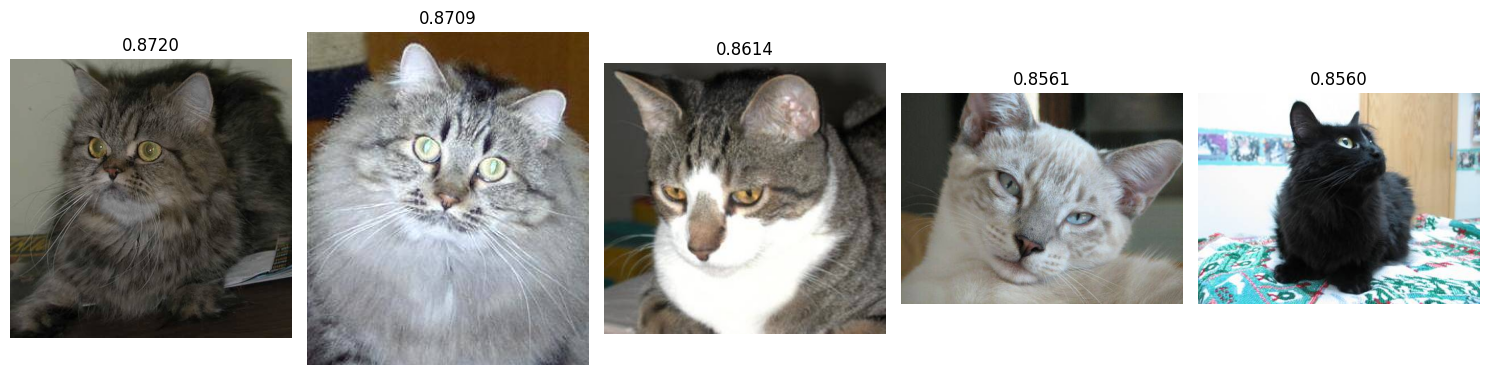

In [60]:
cat_path = os.path.join(os.path.abspath(""), "..", "assets", "magellan.jpg")

results = search_by_image(cat_path)
plot_random_images(results)

🔍 Top 5 similar images to /Users/vasiliy/projects/llm-zoomcamp/02-vector-search/extra/../assets/magellan.jpg:
   1. cat.86.jpg (similarity: 0.8720)
   2. cat.199.jpg (similarity: 0.8709)
   3. cat.38.jpg (similarity: 0.8614)
   4. cat.69.jpg (similarity: 0.8561)
   5. cat.147.jpg (similarity: 0.8560)


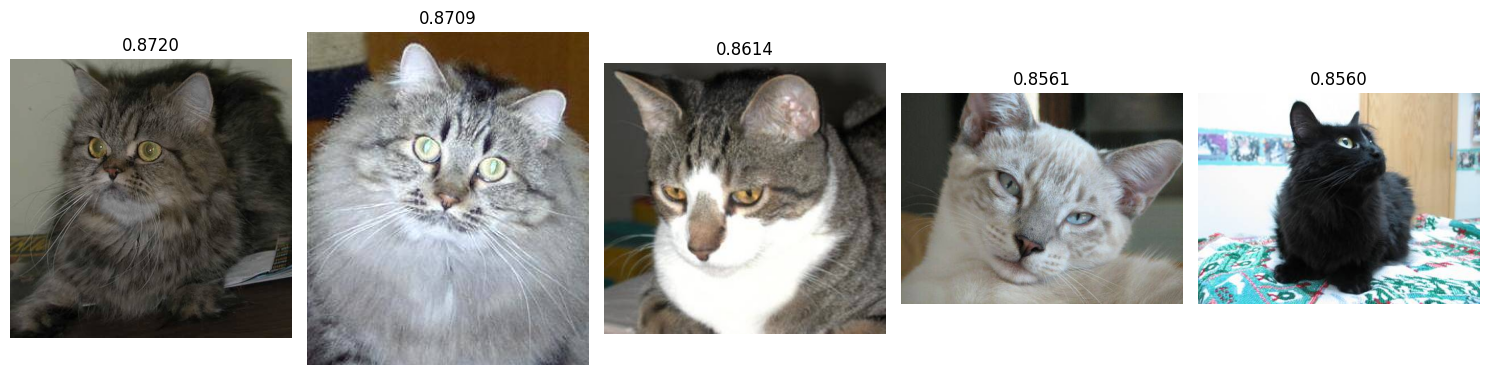

In [61]:
car_path = os.path.join(os.path.abspath(""), "..", "assets", "tesla.jpg")

results = search_by_image(cat_path)
plot_random_images(results)

## Text search


🔍 Text search results for: 'a cat sitting on a chair'
   1. cat.141.jpg (similarity: 0.3006)
   2. cat.63.jpg (similarity: 0.2837)
   3. cat.37.jpg (similarity: 0.2818)
   4. cat.95.jpg (similarity: 0.2713)
   5. cat.35.jpg (similarity: 0.2699)


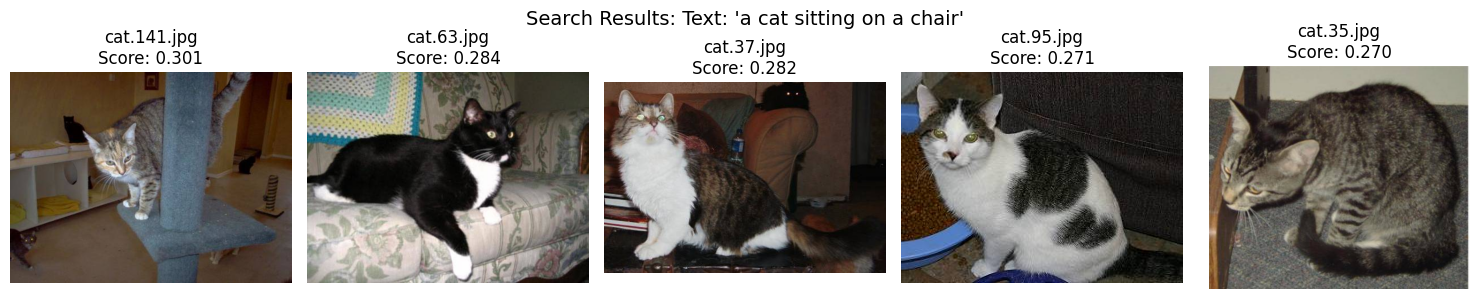


🔍 Text search results for: 'dog playing in the park'
   1. 1768.jpg (similarity: 0.2719)
   2. dog.88.jpg (similarity: 0.2680)
   3. 19741.jpg (similarity: 0.2669)
   4. dog.2.jpg (similarity: 0.2652)
   5. 4691.jpg (similarity: 0.2580)


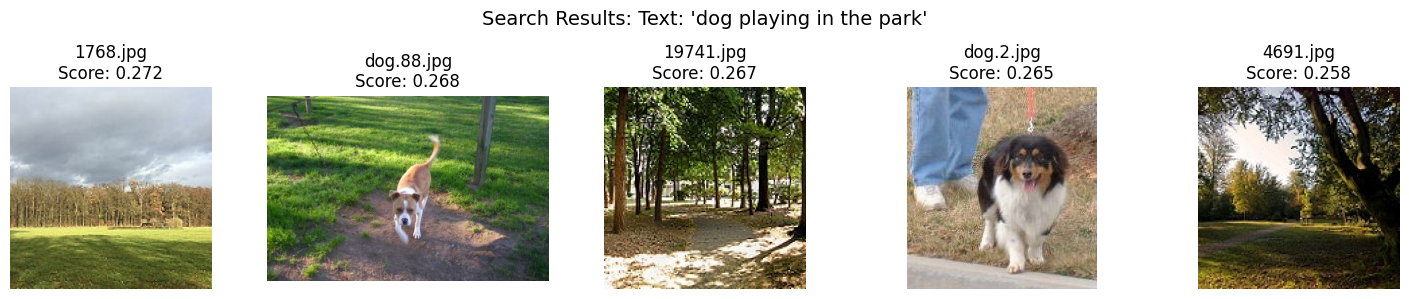


🔍 Text search results for: 'beautiful sunset over mountains'
   1. 13125.jpg (similarity: 0.3066)
   2. 10581.jpg (similarity: 0.3052)
   3. 10000.jpg (similarity: 0.3017)
   4. 8549.jpg (similarity: 0.2987)
   5. 11480.jpg (similarity: 0.2981)


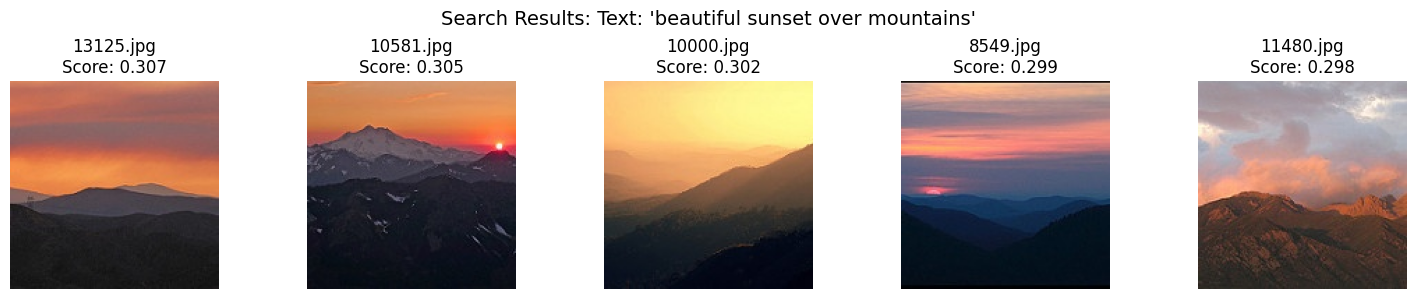


🔍 Text search results for: 'urban city street at night'
   1. 16333.jpg (similarity: 0.3244)
   2. 16004.jpg (similarity: 0.3230)
   3. 10065.jpg (similarity: 0.3205)
   4. 17679.jpg (similarity: 0.3196)
   5. 14071.jpg (similarity: 0.3187)


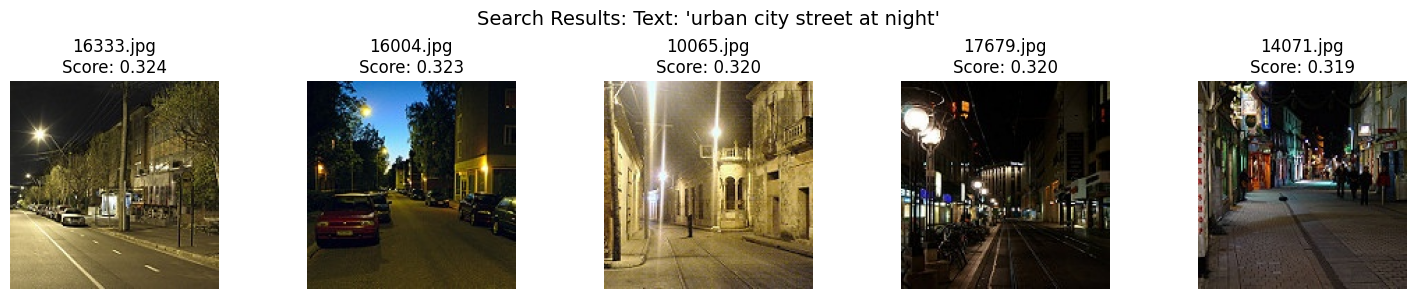


🔍 Text search results for: 'flowers in a garden'
   1. 0200.png (similarity: 0.2828)
   2. 0067.png (similarity: 0.2773)
   3. 0009.png (similarity: 0.2743)
   4. 0002.png (similarity: 0.2731)
   5. 0174.png (similarity: 0.2716)


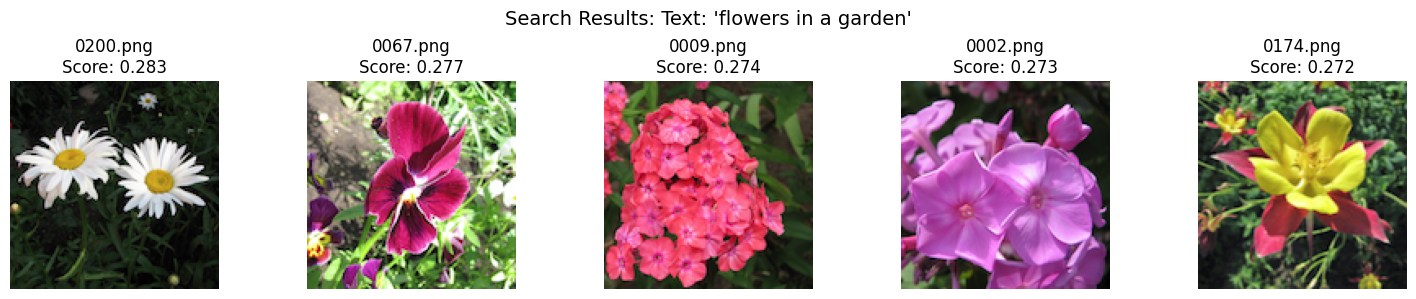


🔍 Text search results for: 'black car on street'
   1. 9720.jpg (similarity: 0.3026)
   2. 7573.jpg (similarity: 0.2960)
   3. 8170.jpg (similarity: 0.2951)
   4. 16004.jpg (similarity: 0.2947)
   5. 17381.jpg (similarity: 0.2944)


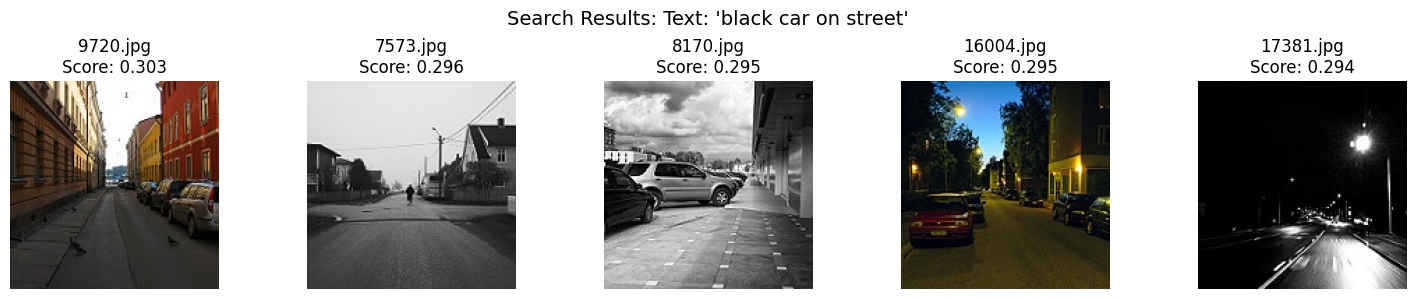

In [62]:
text_queries = [
        "a cat sitting on a chair",
        "dog playing in the park",
        "beautiful sunset over mountains",
        "urban city street at night",
        "flowers in a garden",
        "black car on street"
    ]

for query in text_queries:
    print(f"\n{'=' * 10}")
    text_results = search_by_text(query, limit=5)

    if text_results:
        plot_search_results(
            text_results,
            query_info=f"Text: '{query}'"
        )